In [0]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [0]:
plt.rcParams["figure.figsize"] = (6,6)

In [0]:
import numpy as np
import pandas as pd

In [0]:
import tqdm
import pathlib
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random as rn


TensorFlow 2.x selected.


In [0]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

In [0]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,0.8])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,0.8])
  plt.legend()
  plt.show()

In [0]:
train_target = pd.read_csv('https://sibur.ai-community.com/files/uploads/ea60e971b41e70fece6f266e68a41488/rubber_target_train.csv', index_col="date", parse_dates=["date"],dtype=np.float32)
test_target = pd.read_csv('https://sibur.ai-community.com/files/uploads/c0b27f1fc0ad165fc6c30cd3c7214468/rubber_test_timestamps.csv', index_col="date", parse_dates=["date"],dtype=np.float32)
data = pd.read_csv('https://sibur.ai-community.com/files/uploads/bc4f721232fc48f676f524bd707bdc00/rubber_daily.csv', index_col="date", parse_dates=["date"],dtype=np.float32)

Text(0.5, 1, 'Rubber prices')

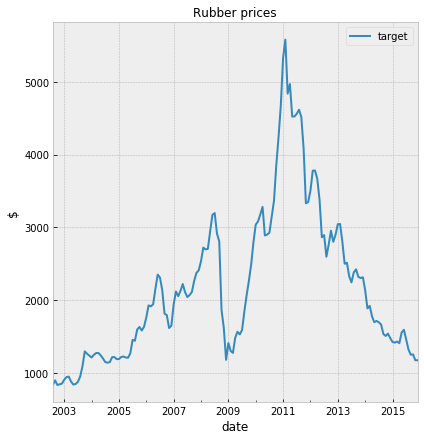

In [183]:
train_target["rubber"].plot(ax=plt.gca(), label="target")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("Rubber prices", fontsize=12)

In [228]:
data

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close
date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,25.639999,25.500000,25.719999,25.389999,8.2770,8.2770,8.2770,8.2770,41.570000,41.570000,41.395000,41.500000,8710.0,8715.0,8669.0,8700.0,15297.5,NaN,NaN,NaN,835.0
2002-07-02,25.750000,25.610001,25.969999,25.600000,8.2769,8.2769,8.2769,8.2769,41.514999,41.560001,41.419998,41.540001,8805.0,8820.0,8720.0,8720.0,15297.0,NaN,NaN,NaN,827.5
2002-07-03,25.840000,25.730000,25.959999,25.520000,8.2768,8.2768,8.2768,8.2768,41.610001,41.645000,41.520000,41.529999,8965.0,8985.0,8790.0,8825.0,15297.5,NaN,NaN,NaN,847.5
2002-07-04,25.549999,25.879999,25.940001,25.500000,8.2767,8.2767,8.2767,8.2767,41.544998,41.619999,41.494999,41.500000,8855.0,8970.0,8790.0,8790.0,15298.5,NaN,NaN,NaN,847.5
2002-07-05,25.730000,25.650000,25.750000,25.420000,8.2766,8.2766,8.2766,8.2766,41.645000,41.639999,41.514999,41.560001,8860.0,8850.0,8815.0,8830.0,15295.0,NaN,NaN,NaN,847.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,64.860001,65.500000,65.790001,64.080002,6.8770,6.8736,6.8873,6.8700,30.665001,30.820000,30.650000,30.809999,14140.0,14170.0,14130.0,14130.0,23291.0,23300.0,23280.0,23290.0,1469.0
2019-06-25,65.050003,64.889999,65.980003,64.169998,6.8798,6.8715,6.8851,6.8655,30.709999,30.750000,30.620001,30.660000,14125.0,14140.0,14090.0,14135.0,23297.0,23305.0,23284.0,23290.0,1495.0
2019-06-26,66.489998,65.800003,66.849998,65.599998,6.8800,6.8876,6.8937,6.8658,30.735001,30.870001,30.700001,30.760000,14175.0,14180.0,14130.0,14130.0,23305.0,23320.0,23287.0,23300.0,1498.0


In [0]:
fts = data.resample("D").mean()

In [383]:
import requests
import io

BASE_URL = "https://www.ncei.noaa.gov/access/services/data/v1"

STATIONS = ["IDM00096087", "VMM00048914", "TH000048426"]
STATIONS_QUERY = f'stations={",".join(STATIONS)}'

DATA_TYPES = ["TAVG", "TMAX", "TMIN", "PRCP"]
DATA_TYPES_QUERY = f'dataTypes={",".join(DATA_TYPES)}'

START = "2002-01-01"
END = "2019-08-01"

BASE_PARAMS = ["units=metric",
               "dataset=daily-summaries",
               f"startDate={START}",
               f"endDate={END}",               
               STATIONS_QUERY,
               DATA_TYPES_QUERY]

response = requests.get("?".join([BASE_URL, "&".join(BASE_PARAMS)]))

assert response.status_code==200

weather_data = pd.read_csv(io.StringIO(response.text), parse_dates=["DATE"])

weather_data.groupby("STATION").count()

weather_data.fillna({"PRCP":0}, inplace=True)
weather_data.ffill(inplace=True)

pd.date_range(START, END, freq="1D")

full_weather_data = []

for station, station_data in weather_data.groupby("STATION"):
    full_weather_data.append(station_data
                     .set_index("DATE")
                     .drop("STATION", axis=1)
                     .rename(lambda cl: f"{cl}_{station}", axis=1))

full_weather_data = pd.concat(full_weather_data, axis=1)
full_weather_data = full_weather_data.reindex(pd.date_range(START, END, freq="1D"))

full_weather_data.fillna({cl:0 for cl in full_weather_data.columns if "PRCP" in cl}, inplace=True)
full_weather_data.ffill(inplace=True)

full_weather_data

,PRCP_IDM00096087,TAVG_IDM00096087,TMAX_IDM00096087,TMIN_IDM00096087,PRCP_TH000048426,TAVG_TH000048426,TMAX_TH000048426,TMIN_TH000048426,PRCP_VMM00048914,TAVG_VMM00048914,TMAX_VMM00048914,TMIN_VMM00048914
2002-01-01,0.0,26.3,NaN,NaN,0.0,25.8,32.5,17.5,0.0,25.4,33.6,22.2
2002-01-02,0.0,26.3,NaN,NaN,0.0,25.3,30.2,17.5,0.0,26.1,30.1,22.6
2002-01-03,0.0,27.3,30.4,23.0,0.0,24.1,29.4,19.6,1.5,24.9,29.0,22.5
2002-01-04,0.0,25.9,30.2,23.0,0.0,25.1,29.8,19.6,0.0,26.4,30.0,22.2
2002-01-05,0.0,27.2,30.6,25.1,0.0,23.8,30.0,19.6,0.0,26.1,29.8,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-28,0.0,28.4,32.7,24.4,0.0,30.6,35.3,26.0,7.1,28.6,33.2,24.5
2019-07-29,0.0,28.8,32.7,25.3,0.0,30.3,36.7,26.0,0.0,28.2,33.6,24.5
2019-07-30,0.0,28.8,32.6,25.3,0.0,30.6,36.4,25.4,8.4,28.7,32.5,25.2
2019-07-31,0.0,28.3,33.0,25.3,0.0,29.9,35.6,26.0,1.3,28.1,31.0,25.2


In [412]:
fts = fts.join(full_weather_data, how="inner")
fts

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close,PRCP_IDM00096087,TAVG_IDM00096087,TMAX_IDM00096087,TMIN_IDM00096087,PRCP_TH000048426,TAVG_TH000048426,TMAX_TH000048426,TMIN_TH000048426,PRCP_VMM00048914,TAVG_VMM00048914,TMAX_VMM00048914,TMIN_VMM00048914
2002-07-01,25.639999,25.500000,25.719999,25.389999,8.2770,8.2770,8.2770,8.2770,41.570000,41.570000,41.395000,41.500000,8710.0,8715.0,8669.0,8700.0,15297.5,NaN,NaN,NaN,835.0,0.0,24.4,28.2,25.0,0.0,29.9,34.9,26.5,0.0,29.8,33.5,26.8
2002-07-02,25.750000,25.610001,25.969999,25.600000,8.2769,8.2769,8.2769,8.2769,41.514999,41.560001,41.419998,41.540001,8805.0,8820.0,8720.0,8720.0,15297.0,NaN,NaN,NaN,827.5,0.0,27.4,31.2,23.8,0.0,29.5,34.0,26.5,0.0,29.0,33.7,26.8
2002-07-03,25.840000,25.730000,25.959999,25.520000,8.2768,8.2768,8.2768,8.2768,41.610001,41.645000,41.520000,41.529999,8965.0,8985.0,8790.0,8825.0,15297.5,NaN,NaN,NaN,847.5,0.0,28.3,31.7,24.8,0.8,29.6,33.8,26.5,4.1,28.7,33.7,26.8
2002-07-04,25.549999,25.879999,25.940001,25.500000,8.2767,8.2767,8.2767,8.2767,41.544998,41.619999,41.494999,41.500000,8855.0,8970.0,8790.0,8790.0,15298.5,NaN,NaN,NaN,847.5,0.0,29.1,31.2,25.4,0.8,29.4,34.7,26.5,21.1,27.1,31.1,24.7
2002-07-05,25.730000,25.650000,25.750000,25.420000,8.2766,8.2766,8.2766,8.2766,41.645000,41.639999,41.514999,41.560001,8860.0,8850.0,8815.0,8830.0,15295.0,NaN,NaN,NaN,847.5,0.0,28.8,31.2,25.6,0.0,29.7,35.1,25.5,22.1,27.1,30.4,24.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,64.860001,65.500000,65.790001,64.080002,6.8770,6.8736,6.8873,6.8700,30.665001,30.820000,30.650000,30.809999,14140.0,14170.0,14130.0,14130.0,23291.0,23300.0,23280.0,23290.0,1469.0,0.0,28.2,32.4,22.6,46.0,29.6,35.1,28.1,0.3,30.2,34.0,27.0
2019-06-25,65.050003,64.889999,65.980003,64.169998,6.8798,6.8715,6.8851,6.8655,30.709999,30.750000,30.620001,30.660000,14125.0,14140.0,14090.0,14135.0,23297.0,23305.0,23284.0,23290.0,1495.0,0.0,29.2,32.3,26.0,1.0,29.9,35.5,25.6,16.3,28.9,33.5,27.0
2019-06-26,66.489998,65.800003,66.849998,65.599998,6.8800,6.8876,6.8937,6.8658,30.735001,30.870001,30.700001,30.760000,14175.0,14180.0,14130.0,14130.0,23305.0,23320.0,23287.0,23300.0,1498.0,0.0,26.8,31.6,26.0,0.3,29.6,35.5,25.9,15.0,27.1,31.4,27.0
2019-06-27,66.550003,66.050003,66.820000,65.629997,6.8771,6.8785,6.8846,6.8738,30.790001,30.799999,30.709999,30.740000,14140.0,14180.0,14135.0,14170.0,23315.0,23330.0,23300.0,23300.0,1503.0,0.0,28.6,32.6,24.2,0.0,28.9,34.3,25.9,20.6,27.8,31.2,24.2


In [0]:
rolling_features = fts.rolling("30D").aggregate("mean")
all_features = rolling_features[rolling_features.index.day==9]

In [415]:
all_features["prediction_date"] = (all_features.index
                                   + pd.TimedeltaIndex(all_features.index.days_in_month-8,
                                                       unit="D"));

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Исключаем признаки, в которых слишком много `NaN`:

In [0]:
COLS = [col for col in all_features if ("USDVND_max" not in col
                                        and "USDVND_min" not in col
                                        and "USDVND_open" not in col)]
final_fts = all_features[COLS].ffill()

In [417]:
final_fts.isna().sum().sort_values(ascending=False).head(5)

prediction_date    0
USDTHB_mid         0
brent_open         0
brent_max          0
brent_min          0
dtype: int64

In [418]:
df = train_target.join(final_fts.set_index("prediction_date"), how="outer")
df.index.name = "date"
df.shape

(204, 19)

In [419]:
df[TARGET].isna().sum()

43

In [0]:
df["month"] = df.index.month
FCOLS = df.columns[1:]
TARGET = "rubber"

In [407]:
df.head()

,rubber,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,USDTHB_min,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,rubber_close,PRCP_IDM00096087,TAVG_IDM00096087,TMAX_IDM00096087,TMIN_IDM00096087,PRCP_TH000048426,TAVG_TH000048426,TMAX_TH000048426,TMIN_TH000048426,PRCP_VMM00048914,TAVG_VMM00048914,TMAX_VMM00048914,TMIN_VMM00048914,month
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-08-01,830.595215,25.537143,25.595714,25.755714,25.305714,8.276757,8.276757,8.276757,8.276757,41.509999,41.576429,41.414999,41.512857,8857.857143,8885.000000,8778.428571,8804.714286,15296.714286,838.928571,0.000000,28.211111,31.277778,25.477778,0.244444,29.611111,34.277778,26.144444,7.600000,28.222222,31.844444,25.844444,8
2002-09-01,895.476196,25.560476,25.546190,25.831429,25.254285,8.276805,8.276805,8.276805,8.276805,41.468096,41.588810,41.189238,41.375476,9039.500000,9099.761905,8923.333333,9010.000000,15311.238095,800.119048,0.000000,27.563333,31.360000,24.460000,6.473333,28.496667,33.513333,25.443333,4.160000,28.256667,32.206667,25.636667,9
2002-10-01,831.304321,27.148000,27.040500,27.417500,26.794500,8.276815,8.276815,8.276815,8.276815,42.131250,42.216500,42.031000,42.121500,8854.625000,8883.750000,8815.300000,8852.000000,15327.700000,867.000000,0.603333,27.683333,31.050000,25.010000,6.410000,28.043333,32.616667,25.240000,14.816667,27.416667,31.120000,24.960000,10
2002-11-01,840.250000,28.505000,28.577273,28.860455,28.249091,8.277064,8.277064,8.277064,8.277064,43.250000,43.303864,43.086363,43.170455,9000.568182,9008.363636,8972.272727,8988.454545,15341.000000,872.159091,0.830000,27.576667,31.036667,24.113333,5.036667,27.750000,32.463333,24.940000,11.103333,27.360000,31.273333,25.153333,11
2002-12-01,849.875000,26.156500,26.316500,26.603500,25.938500,8.276955,8.276955,8.276955,8.276955,43.541750,43.622499,43.442000,43.550000,9212.900000,9235.250000,9145.900000,9194.300000,15360.950000,828.125000,0.220000,27.610000,31.326667,24.980000,1.603333,27.790000,32.583333,24.130000,6.126667,27.840000,31.643333,25.320000,12


In [0]:
tr = df[:"2013"].copy()
cv = df["2014":"2015"].copy()
ts = df["2016":].copy()

Text(0.5, 1, 'Rubber prices')

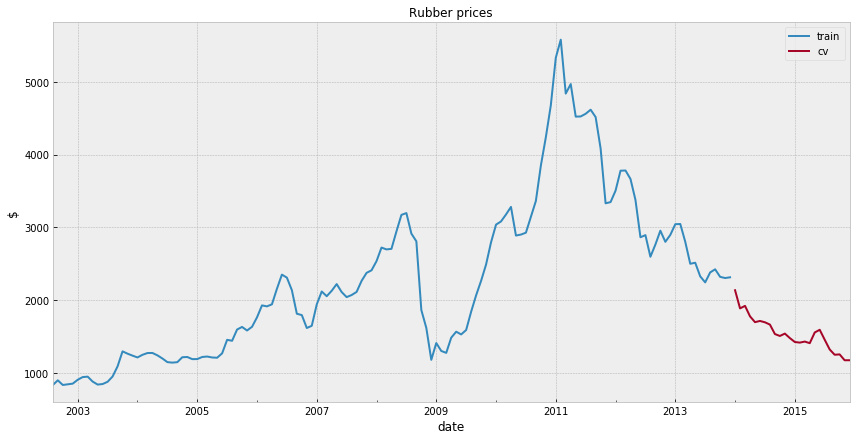

In [422]:
tr["rubber"].plot(ax=plt.gca(), label="train")
cv["rubber"].plot(ax=plt.gca(), label="cv")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("Rubber prices", fontsize=12)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

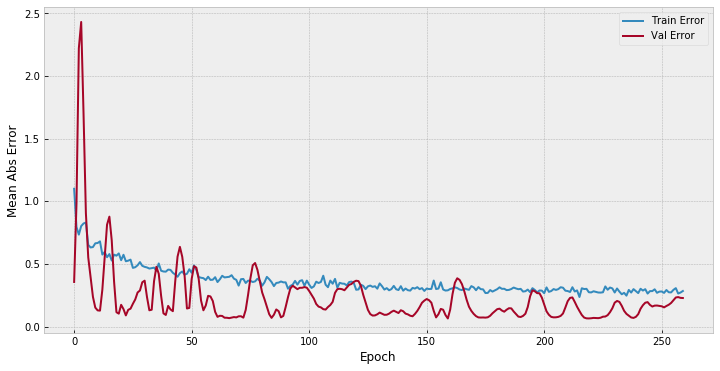

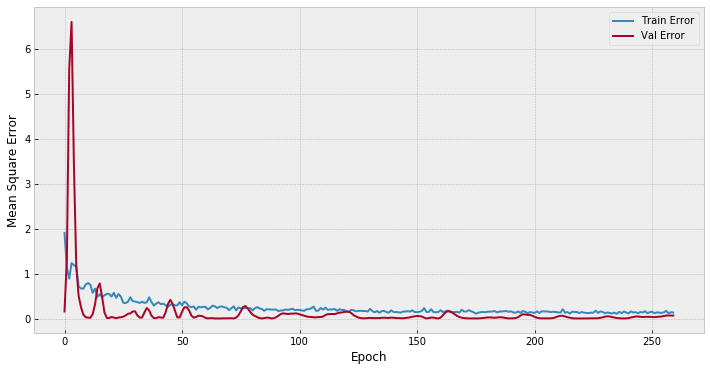

MAPE (training set): 9.92%
MAPE (cross-validation set): 4.71%


In [423]:
RS=77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

tf.keras.backend.clear_session()

EPOCHS = 500
BS = 128

tr = df[:"2013"].copy()
cv = df["2014":"2015"].copy()
ts = df["2016":].copy()

center, scale = tr[FCOLS].mean().values, tr[FCOLS].std().values
trn = (tr[FCOLS] - center)/scale
cvn = (cv[FCOLS] - center)/scale

y_trn = tr[TARGET].values
y_cv =  cv[TARGET].values

model = keras.Sequential([
  layers.Input(shape=(len(FCOLS))),
  layers.Dense(128),
  layers.Dropout(0.3),
  layers.Dense(64),
  layers.Dropout(0.2),
  layers.Dense(16),
  layers.Dropout(0.1),
  layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer='adam', metrics=['mae', 'mse'], loss='mse') #tf.keras.losses.Huber())
model.summary()
model.reset_states()

lr_schedule = keras.callbacks.ReduceLROnPlateau(verbose=0, factor=0.1)

history = model.fit(trn, (y_trn - y_trn.mean())/y_trn.std(),
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=0,
          validation_data=(cvn, (y_cv - y_trn.mean())/y_trn.std()),
          callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
            #lr_schedule,
            keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True ) 
          ])  
model = tf.keras.models.load_model('my_checkpoint.h5')
model.reset_states()

plot_history(history)

tr_preds = model.predict(trn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
cv_preds = model.predict(cvn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr[TARGET].index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv[TARGET].index, name="activity_pred")

print(f"MAPE (training set): {100 * mape(y_trn, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(y_cv, cv_preds.values):.2f}%")


In [0]:
'''
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1, 0, 2])
'''

TR performance: 9.9%
CV performance: 4.7%


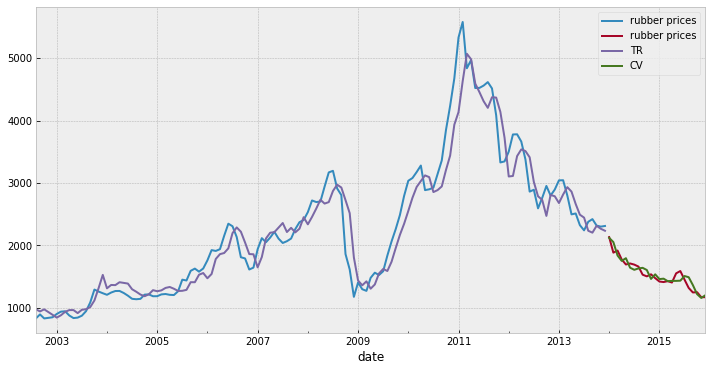

In [424]:
print(f"TR performance: {100 * mape(tr[TARGET], tr_preds):0.1f}%")
print(f"CV performance: {100 * mape(cv[TARGET], cv_preds):0.1f}%")

plt.figure();
tr[TARGET].plot(ax=plt.gca(), label="rubber prices");
cv[TARGET].plot(ax=plt.gca(), label="rubber prices");
tr_preds.plot(ax=plt.gca(), label="TR");
cv_preds.plot(ax=plt.gca(), label="CV");
plt.legend(loc=0);


Визуализируем предсказания:

Считаем предсказания для тестового набора:

In [425]:
tst = (df[FCOLS] - center)/scale

ts_preds = model.predict(tst, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
ts_preds = pd.DataFrame(ts_preds, columns=["rubber"], index=df.index)
ts_preds.loc[test_target.index].to_csv("rubber_NN.csv")

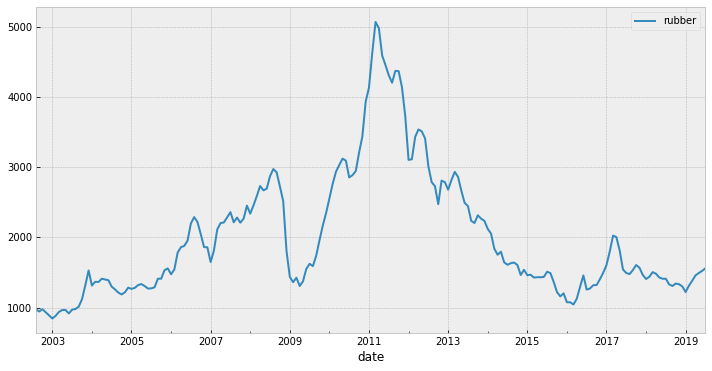

In [426]:
tst = (df[FCOLS] - center)/scale

ts_preds = model.predict(tst, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
ts_preds = pd.DataFrame(ts_preds, columns=["rubber"], index=df.index)

plt.rcParams["figure.figsize"] = (12,6)
ts_preds.plot();